<!--# Using the Trainer feature-->
# Trainer 사용해보기

<!--Chain has a feature called `Trainer` that can often be used to simplify the process of training and evaluating a model. This feature supports training a model in a way such that the user is not required to explicitly write the code for the training loop. For many types of models, including our MNIST model, `Trainer` allows us to write our training and evaluation code much more concisely.-->
Chainer에는 model의 학습과 평가 과정을 간단히 하기 위해 `Trainer` 라는 클래스를 가지고 있습니다. 이 클래스는 유저로 하여금 직접 반복학습을 명시하지 않아도 되게끔해줍니다. MNIST model을 포함한 많은 타입의 model들은 `Trainer`를 사용하여 학습 및 평가를 하게하는 코드를 간결하게 작성할 수 있습니다. 

<!--Chainer contains several extensions that can be used with `Trainer` to visualize your results, evaluate your model, store and manage log files more easily.-->
Chainer는 결과를 시각화 해주거나, model을 평가하거나, 로그를 저장, 관리하는 등의 확장 기능을 `Trainer`와 함께 사용할 수 있도록 하고 있습니다.

<!--This example will show how to use the Trainer feature to train a fully-connected feed-forward neural network on the MNIST dataset.-->
이 예제에서는 Trainer를 사용하여 MNIST 데이터셋을 통해 fully-connected feed-forward neural network를 학습시킬 것입니다.

<!--## 1. Prepare the dataset-->
## 1. 데이터셋 준비하기

<!--Load the MNIST dataset, as in the previous notebook.-->
이전 notebook 에서 했던 것 처럼 먼저 MNIST 데이터셋을 불러옵니다.

In [1]:
from chainer.datasets import mnist

train, test = mnist.get_mnist()

<!--## 2. Prepare the dataset iterators-->
## 2. 데이터셋 반복자 준비하기

In [2]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

<!--## 3. Prepare the Model-->
## 3. model 준비하기

<!--We use the same model as before. -->
이전에 사용했던 모델을 그대로 쓸 것입니다.

In [3]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # 상위 초기화자를 이용하여 Link들을 등록함
        '''
        # Chainer v1
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(None, n_mid_units),
            l3=L.Linear(None, n_out),
        )
        '''
        # Chainer v2
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)

    def __call__(self, x):
        # x(입력 데이터)를 사용하여 forward pass를 표현함
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0

model = MLP()
model.to_gpu(gpu_id)

<!--## 4. Prepare the Updator-->
## 4. Updater 준비하기
<!--As mentioned above, the trainer object (instance of `Trainer`) actually implements the training loop for us. However, before we can use it, we must first prepare another object that will actually perform one iteration of training operations and pass it to the trainer. This other object will be an subclass of `Updator` such as `StandardUpdater` or a custom subclass. It will therefore need to hold all of the components that are needed in order to perform one iteration of training, such as a dataset iterator, and and optimizer that also holds the model.-->
위에서 설명드렸듯이, trainer 객체(`Trainer`의 인스턴스)는 반복학습 직접 코드를 직접 작성하지 않아도 수행해줍니다. 그러나 사용하기 이전에 한번의 반복주기를 수행한 뒤 trainer 객체에 데이터를 넘겨주는 또다른 객체를 먼저 준비해야합니다. `StandardUpdater`나 커스텀 서브클래스와 같은 이러한 객체들은 `Updater`의 서브클래스입니다. 따라서 한번 반복주기를 수행하기 위해 필요한 모든 데이터(데이터셋을 가진 Iterator, model을 가지고 있는 optimizer)를 이 객체에게 넘겨주어야 합니다.

- Updater
    - Iterator
        - Dataset(데이터셋)
    - Optimizer
        - Model

<!--Since we can also write customized updaters, they can perform any kinds of computations. However, for this example we will use the `StandardUpdater` which performs the following steps each time it is called:-->
임의의 updater를 만들어 어떠한 종류의 계산이라도 수행할 수 있게 할 수 있습니다. 그러나 이 예제에서는 매 시간마다 아래와 같은 단계를 수행하는 `StandardUpdater`를 사용할 것입니다 :

<!--1. Retrieve a batch of data from a dataset using the iterator that we supplied.-->
1. 반복자를 통해 그 안에 넣어준 데이터셋에서 batch를 반환받습니다.
<!--2. Feed the batch into the model and calculate the loss using the optimizer that we supplied. Since we will supply the model to the optimizer first, this means that the updater can also access the model from the optimizer.-->
2. optimizer를 사용하여 model 안에 batch를 넣어주고 loss를 계산해줍니다. 이전에 optimizer 안에 model을 넣어주었기 때문에 updater는 optimizer를 통해 model에 접근할 수 있게 됩니다.
<!--3. Update the model parameters using the optimizer that we supplied.-->
3. optimizer를 사용하여 model 파라미터들을 갱신합니다.

<!--Once the updater has been set up, we can pass it to the trainer and start the training process. The trainer will then automatically create the training loop and call the updater once per iteration.-->
updater가 세팅이 완료되었다면 trainer에 넘겨 바로 학습 과정을 수행할 수 있습니다. updater을 넘겨받으면 trainer는 스스로 반복학습 루틴을 생성하고 매 반복주기마다 updater를 호출하게 됩니다.

<!--Now let's create the updater object.-->
이제 updater 객체를 만들어봅시다.

In [4]:
from chainer import optimizers
from chainer import training

max_epoch = 10
# Note: 만약 gpu가 없다면 아래의 값을 -1로 설정하세요.
gpu_id = 0

# Note : L.Classifier 는 model을 감싸는 chain으로 loss 함수를 추가해주는 역할을 합니다.
# 여기에서는 loss 함수에 대해 기재하지 않았기 때문에 기본값으로 'softmax_cross_entropy'가 사용됩니다.
# 수정된 model의 출력값은 예측된 라벨이 아닌 loss값이 될 것입니다.
model = L.Classifier(model)

# GPU에 model 설정
model.to_gpu(gpu_id)

# 최적화 메서드 설정
optimizer = optimizers.SGD()
# optimizer에 나의 model 세팅함
optimizer.setup(model)

# updater에게 iterator와 optimizer 둘다 사용할 수 있게 설정해줌
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

### NOTE

<!--The `L.Classifier` object is actually a chain that places our `model` in its `predictor` attribute. This modifies `model` so that when it is called, it will now take both the input image batch and a class label batch as inputs to its `__call__` method and output a `Variable` that contains the loss value. The loss function to use can be optionally set but we use the default which is `softmax_cross_entropy`.-->
`L.Classifier` 는 `predictor` 속성 안에 `model`을 두는 chain 객체입니다. 이를 통해 수정된 `model`은 입력으로 이미지 batch와 라벨 batch를 `__call__` 메서드를 통해 받아 loss 값을 가지는 `Variable` 객체를 출력합니다. 부가적으로 loss함수를 설정해줄 수도 있지만 여기에서는 기본값인 `softmax_cross_entropy`를 사용하였습니다.

<!--Specifically, when `__call__` is called on our model (which is now a `L.Classifier` object), the image batch is supplied to its `predictor` attribute, which contains our `MLP` model. The ourput of the `MLP` (which consists of class label predictions) is supplied to the loss function along with the target class labels to compute the loss value which is then returned as a `Variable` object.-->
구체적으로 말씀드리자면 `__call__` 메서드가 model에서 호출 된다면(위의 내용에 따라 이제는 `L.Classifier` 객체겠지만요) 이미지 batch를 `MLP` model을 담고 있는 `predictor` 속성에 넣게되고 `MLP`의 출력값(예측된 라벨 클래스겠죠)은 다시 loss 함수에 넣어 loss값을 계산하게되고 이것을 `Variable` 객체 형태로 만들어 반환하게 됩니다.

<!--Note that we use `StandardUpdater`, which is the simplest type of `Updater` in Chainer. There are also other types of updaters available, such as `ParallelUpdater` (which is intended for multiple GPUs) and you can also write a custom updater if you wish.-->
Chainer에서 가장 간단한 종류의 `Updater`인 `StandardUpdater`를 사용중인 것을 참고하세요. 이것 외에도 `ParallelUpdater`(다중 GPU를 사용하기위한 updater) 와 같이 다른 종류의 updater 또한 존재하는데 이 외에도 원한다면 직접 작성한 커스텀 updater를 사용할 수도 있습니다.

<!--## 5. Setup Trainer-->
## 5. Trainer 설정하기
<!--Now that we have set up an updater, we can pass it to a `Trainer` object. You can optionally pass a `stop_trigger` to the second trainer argument as a tuple, `(length, unit)` to tell the trainer stop automatically according to your indicated timing. The `length` is given as an arbitrary integer and `unit` is given as a string which currently must be either 'epoch' or 'iteration'. Without setting `stop_trigger`, the training will not stop automatically.-->
updater에 대한 설정을 마쳤으니 이제 이것을 `Trainer` 객체에 넘겨줍니다. 부가적으로 두 번째 인수로 튜플 형태의 `stop_trigger`를 넣어주어 정해진 시간이 지나면 학습을 자동으로 멈추게 할 수 있습니다. `unit`에는 'epoch' 혹은 'iteration'(반복횟수)를 문자열 로 넘겨주고 `length`에 `unit`에 해당되는 임의의 정수를 넘겨줍니다. `stop_trigger` 옵션을 설정하지 않는다면 자동으로 학습이 멈추지 않습니다.

In [5]:
# Trainer에 Updater 설정
trainer = training.Trainer(updater, (max_epoch, 'epoch'),
                           out='mnist_result')

<!--The `out` argument in the trainer will set up an output directory to save the logfiles, the image files of graphs to show the time progress of loss, accuracy, etc. -->
trainer의 `out` 인수를 통해 로그 파일이나 그래프, loss 계산정도, 정확도 등의 데이터들의 저장 디렉토리를 설정할 수 있습니다.

<!--Next, we will explain how to display/save those outputs by using 'Extension'. -->
밑의 내용에서는 'Extension'(확장기능)을 사용하여 어떻게 출력결과를 나타내거나 저장하는지에 대해 설명해보겠습니다.

<!--## 6. Add extensions to trainer-->
## 6. trainer에 확장기능 추가하기
<!--There are several optional trainer extensions that provide the following capabilites: -->
아래와 같은 기능들이 trainer의 확장기능으로써 제공되고 있습니다 :

<!--- Save log files automatically ('LogReport')-->
- 로그 파일 자동저장('LogReport')
<!--- Display the training information to the terminal periodically ('PrintReport')-->
- 주기적으로 학습 관련 정보를 표시('PrintReport')
<!--- Visualize the loss progress by plottig a graph periodically and save its image ('PlotReport')-->
- loss 진행 과정을 주기적으로 그래프에 표시하고 이미지로 저장('PlotReport')
<!--- Automatically serialize the model or the state of Optimizer periodically ('snapshot'/'snapshot_object')-->
- 주기적으로 model이나 optimizer의 상태를 변환하여 저장('snapshot'/'snapshot_object')
<!--- Display Progress Bar to show the progress of training ('ProgressBar')-->
- 학습 진척도를 진행바로 표시('ProgressBar')
<!--- Save the model architechture as a dot format readable by Graphviz ('dump_graph')-->
- Graphviz에서 읽을 수 있도록 model 구조를 점 포멧으로 저장('dump_graph')

<!--Now you can utilize the wide variety of tools shown above right away! To do so, simply pass the desired `Extension` object to the `Trainer` object by using the `extend()` method of `Trainer`.-->
이제 위의 다양한 기능들을 바로 사용할 수 있습니다! 사용하려면 단순히 `Trainer` 객체에 `Extension` 객체를 `extend()` 라는 메서드에 넣어주기만 하면 됩니다. 아래와 같이요.

In [6]:
from chainer.training import extensions

trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

### `LogReport`

<!--Collect 'loss' and 'accuracy' automatically every 'epoch' or 'iteration' and store the information under the 'log' file in the directory assigned by the 'out' argument of 'Trainer'-->
매 'epoch' 혹은 반복 주기마다 loss 와 정확도를 모아서 Trainter에 out인수로 지정한 디렉토리 주소에 log 파일을 만들고 저장합니다.

### `snapshot`

<!--The 'snapshot' method saves the 'Trainer' object at the designated timing (defaut: every epoch) in the directory assigned by 'out' argument in 'Trainer'. The 'Trainer' object, as mentioned before, has an 'Updater' which contains an 'Optimizer' and a model inside. Therefore, as long as you have the snapshot file, you can use it to come back to the training or make inferences using the previously trained model later. -->
'snapshot' 메서드는 'Trainer'에서 'out' 인수로 지정한 디렉토리 주소에 지정한 시간마다 'Trainer' 객체를 저장합니다. 이전에도 언급했지만 'Trainer' 객체는 model을 담고있는 'Optimizer'를 가지는 'Updater'를 보유하고 있습니다. 따라서 스냅샷 파일만 있다면 나중에 언제든지 해당 학습 지점으로 돌아오거나, 학습이 끝난 파라미터를 불러올 수 있습니다.

### `snapshot_object`

<!--When you save the whole 'Trainer' object, in some cases it is very tedious to retrieve only the inside of the model. By using 'snapshot_object', you can save the particular object (in this case, the model wrapped by `Classifier`) in addition to saving the `Train` object. `Classifier` is a `Chain` object that keeps the `Chain` object given by the first argument as a property called `predictor` and calculates the loss. `Classifier` doesn't have any parameters other than those inside its predictor model, and so we only save `model.predictor`. -->
만약 'Trainer' 객체 전체를 저장하게 되면 몇몇 경우에서 model 내부의 파라미터만 저장하고 싶을 경우가 있을겁니다. 이럴 때 'snapshot_object'를 사용하면 `Train` 객체를 저장하는것 뿐만 아니라 일부만을 따로 저장할 수 있게됩니다(이 경우 `Classifier`로 래핑된 model이 저장됩니다). `Classifier`는 첫번째 인자로 받은 `Chain` 객체를 `predictor`라 불리우는 속성으로 저장하고 loss를 계산하는 `Chain` 입니다. `Classifier`는 predictor model 외에 어떠한 파라미터를 갖지않기 때문에 따라서 `model.predictor`만 저장될 것입니다.

### `dump_graph`

<!--This method saves the computational graph of the model. The graph is saved in Graphviz dot format. The output location (directory) to save the graph is set by the 'out' argument of `Trainer`. -->
이 메서드는 model의 계산 그래프를 저장합니다. 그래프는 Grapviz dot 포멧 형식으로 저장됩니다. 저장 디렉토리는 앞서 `Trainer`에서 설정했던 'out' 인수를 참조하여 저장하게 됩니다.

### `Evaluator`

<!--The 'Iterator' that uses the evaluation dataset (such as a validation or test dataset) and the model object are passed to 'Evaluator'. The 'Evaluator' evaluates the model using the given dataset at the specified timing interval. -->
'Evaluator'는 'Iterator'에서 넘겨받은 model과 평가 데이터셋(검증 데이터셋 혹은 테스트 데이터셋)을 사용합니다.
'Evaluator'는 매 특정 시간 마다 주어진 데이터셋과 통해 model을 평가하는 역할을 수행합니다.

### `PrintReport`

<!--`Reporter` aggregates the results to output to the standard output. The timing for displaying the output can be given by the list. -->
`Reporter` 는 결과를 표준 출력으로 내보내는 역할을 수행합니다. 결과를 출력하는 시기를 리스트(list)를 넘겨줌으로써 설정할 수 있습니다.

### `PlotReport`

<!--`PlotReport` plots the values specified by its arguments, draws the graph and saves the image in the directory set by 'file name'.-->
`PlotReport` 특정한 인수의 값을 표에 나타내고 그래프를 그린뒤 설정된 'file name' 이라는 이름으로 이미지를 저장합니다.

<!--The `Extension` class has a lot of options other than those mentioned here. For instance, by using the 'trigger' option, you can set individual timings to activate the 'Extension' more flexibly. Please take a look at the official document in more detail：[Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)-->
`Extension` 클래스는 여기서 언급한것 외에도 수많은 옵션들이 있습니다. 예를 들어, 'trigger' 옵션을 사용할 경우 'Extension'에 각각 독립적인 텀을 부여해 보다 유연성을 갖출 수 있게 설정 할 수 있습니다. 자세한 내용은 공식 문서를 확인해주세요 : [Trainer extensions](http://docs.chainer.org/en/latest/reference/extensions.html)

<!--## 7. Start Training-->
## 7. 학습 시작하기
<!--To start training, just call 'run' method from 'Trainer' object.-->
학습을 시작하기 위해서는 'Trainer' 객체의 'run' 메서드를 부르기만 하면 됩니다.

In [7]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.59153     0.595449       0.813334              0.814873                  2.30725       
2           0.613205    0.847981       0.462777              0.880241                  4.25146       
3           0.431657    0.883595       0.3727                0.895273                  6.20694       
4           0.369589    0.896701       0.334184              0.906744                  8.21228       
5           0.337059    0.904534       0.308388              0.911986                  10.2158       
6           0.315168    0.910348       0.291701              0.916634                  12.1821       
7           0.297655    0.915095       0.278178              0.921479                  14.1874       
8           0.283525    0.919338       0.267326              0.924446                  16.1402       
9           0.27153     0.922575       0.257733              0.926325               

<!--Let's see the graph of loss saved in the 'mnist_result' directory. -->
'mnist_result' 디렉토리를 확인하여 loss 그래프가 저장되었는지 봅시다.

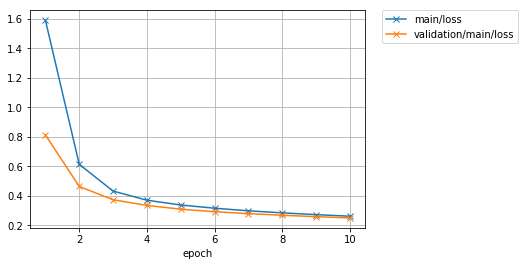

In [8]:
from IPython.display import Image
Image(filename='mnist_result/loss.png')

<!--How about the accuracy? -->
정확도도 볼까요?

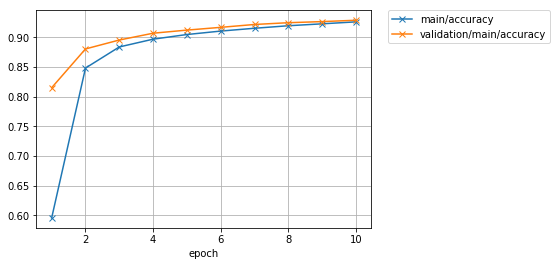

In [9]:
Image(filename='mnist_result/accuracy.png')

<!--Furthermore, let's visualize the computaional graph output by 'dump_graph' of 'Extension' using 'Graphviz'. -->
더 나아가서 계산 그래프를 'Graphviz'를 사용하는 확장기능('Extension')인 'dump_graph'를 통해 저장된 출력값을 시각화해봅시다.

>(graphviz 가 설치되어있어야 동작합니다!)

In [14]:
%%bash
dot -Tpng mnist_result/cg.dot -o mnist_result/cg.png

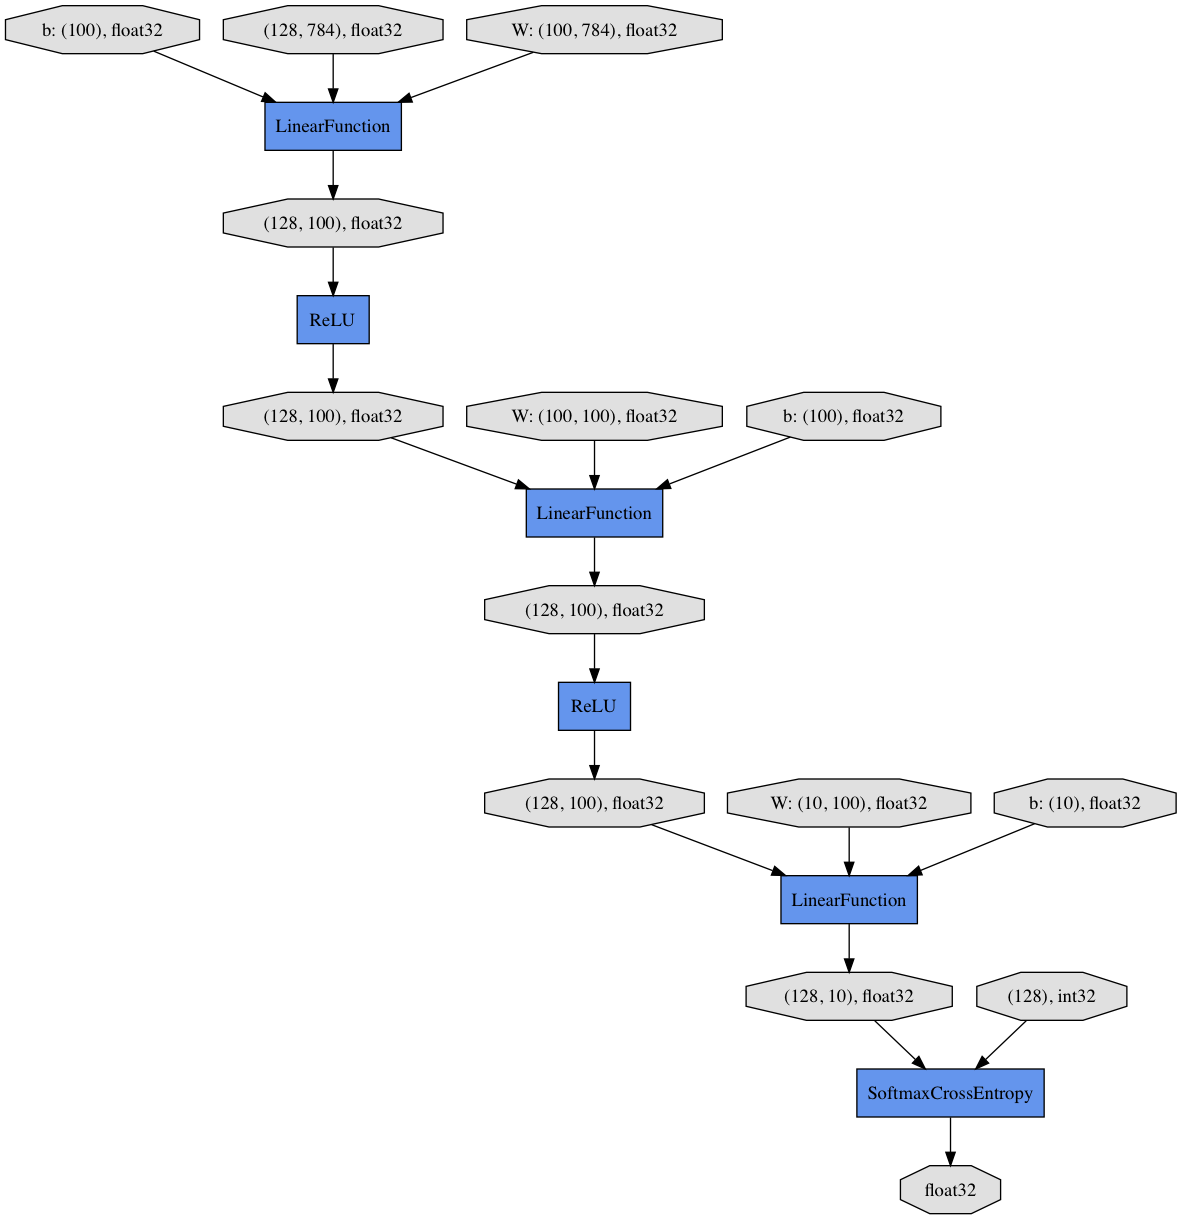

In [15]:
Image(filename='mnist_result/cg.png')

<!--From the top to the bottom, you can track the data flow of the computations, how data and paremeters are passed to what type of 'Function' and the calculated loss is output. -->
위에서부터 아래로 계산 흐름을 쉽게 찾아갈 수 있으며 데이터와 파라미터들이 어떠한 종류의 함수(Link 혹은 Function)를 어떻게 거쳤는지 그리고 최종 출력값으로써 loss가 어떻게 계산되었는지 알 수 있습니다.

<!-- ## 8. Evaluate a pre-trained model-->
## 8. 미리 학습된 model 평가하기

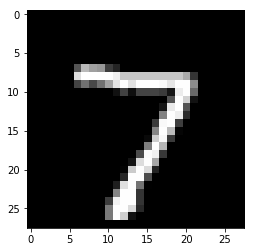

label: 7
predicted_label: 7


In [11]:
import numpy as np
from chainer import serializers
from chainer.cuda import to_gpu
from chainer.cuda import to_cpu

model = MLP()
serializers.load_npz('mnist_result/model_epoch-10', model)
model.to_gpu(gpu_id)

%matplotlib inline
import matplotlib.pyplot as plt

x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

x = to_gpu(x[None, ...])
y = model(x)
y = to_cpu(y.data)

print('predicted_label:', y.argmax(axis=1)[0])

<!--It successfully executed !!-->
정상적으로 실행되었지요?